# Data Preparation

## Import Library

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from tqdm.notebook import tqdm

from IPython.display import display
from sklearn.utils import resample 

In [60]:
RANDOM_STATE = 42
oversampling_target = 5000

undersampling_theshold = 30000
a = 0.5
b = 0.05

# Load Data

In [61]:
dataset_path = 'dataset'
df_train = pd.read_csv(dataset_path + "/train.csv")
df_test = pd.read_csv(dataset_path + "/test.csv")

In [62]:
print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)
record_train = df_train.shape[0]

Train data shape:  (204622, 14)
Test data shape:  (10810, 2)


In [63]:
df_train.head(1)

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_test.head()

,id,comment
0,0,ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1,1,อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2,2,ขยะที่แยกสะพานควาย
3,3,ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4,4,- ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...


# Reading Raw Data

## Labels

In [65]:
label_cols = df_train.columns[2:].values.tolist()
print('Number of label columns:', len(label_cols))
print('Label columns:')
for i,l in enumerate(label_cols) : 
    print(f'{i+1}. {l}')

Number of label columns: 12
Label columns:
1. สำนักงานตำรวจแห่งชาติ
2. การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย
3. สภาเด็กและเยาวชนกรุงเทพมหานคร
4. กรมควบคุมมลพิษ
5. กรมสรรพสามิต
6. การไฟฟ้านครหลวง
7. กรมทางหลวง
8. สำนักงานประกันสุขภาพแห่งชาติ
9. การประปานครหลวง
10. คณะกรรมการการพัฒนาเศรษฐกิจ
11. กระทรวงการท่องเที่ยวและกีฬา
12. สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200


### Number of Record with Label

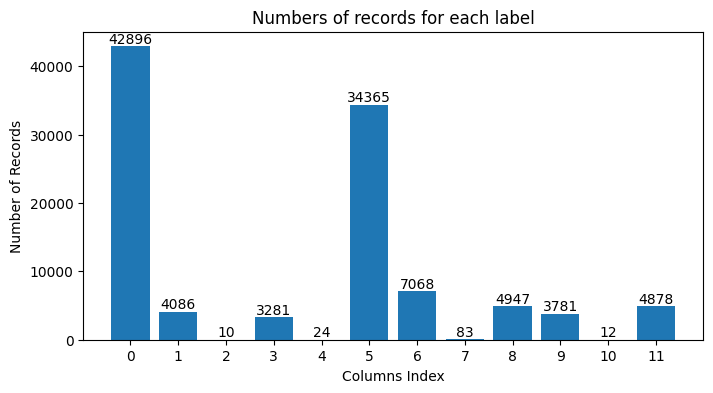

In [66]:
# count label
int_label = np.arange(0,12)
plt.figure(figsize=(8, 4))
bars = plt.bar(int_label, df_train.iloc[:, 2:].sum().tolist())

# Display the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xticks(int_label)
plt.xlabel('Columns Index')
plt.ylabel('Number of Records')
plt.title('Numbers of records for each label')
plt.show()

In [67]:
data = []

# Loop through columns and collect index, label, and counts
for index, column in enumerate(df_train.columns[2:].values):
    data.append([column, df_train[column].sum()])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=["Label", "Counts"])

# Print DataFrame in a readable format
df_summary

,Label,Counts
0,สำนักงานตำรวจแห่งชาติ,42896
1,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,4086
2,สภาเด็กและเยาวชนกรุงเทพมหานคร,10
3,กรมควบคุมมลพิษ,3281
4,กรมสรรพสามิต,24
5,การไฟฟ้านครหลวง,34365
6,กรมทางหลวง,7068
7,สำนักงานประกันสุขภาพแห่งชาติ,83
8,การประปานครหลวง,4947
9,คณะกรรมการการพัฒนาเศรษฐกิจ,3781


## Oversampling Underrepresent Data

In [68]:
# Identify columns with fewer than 100 records
label_counts = df_train.iloc[:, 2:].sum()
underrepresented_labels = label_counts[label_counts < oversampling_target].index

# Create a copy of the original dataset
df_oversampled = df_train.copy()

# Use tqdm to track progress
for label in tqdm(underrepresented_labels, desc="Oversampling Progress"):
    # Select rows where this label is present
    subset = df_train[df_train[label] == 1]
    
    sample_target = oversampling_target
    
    # sample based on the number of records
    # if len(subset) < 50 :
    #     sample_target = int(len(subset) * 150)
    # elif len(subset) < 100 :
    #     sample_target = int(len(subset) * 50)
    # else :
    #     sample_target = oversampling_target
    
    # Oversample with replacement
    oversampled_subset = resample(subset, 
                                  replace=True, 
                                  n_samples=sample_target - len(subset),
                                  random_state=RANDOM_STATE)
    
    # Append to the original dataset
    df_oversampled = pd.concat([df_oversampled, oversampled_subset], ignore_index=True)

print(f"Oversampling completed. New dataset size: {df_oversampled.shape}")


Oversampling Progress:   0%|          | 0/9 [00:00<?, ?it/s]

Oversampling completed. New dataset size: (228520, 14)


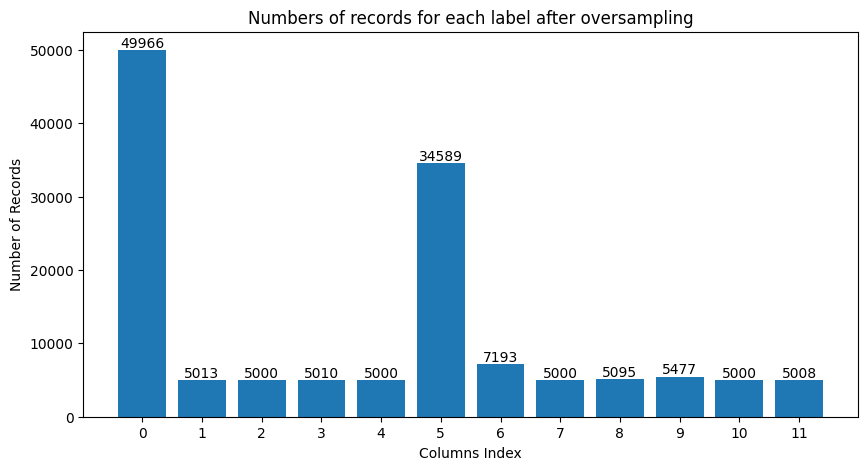

In [69]:
# count label
int_label = np.arange(0,12)
plt.figure(figsize=(10, 5))
bars = plt.bar(int_label, df_oversampled.iloc[:, 2:].sum().tolist())

# Display the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xticks(int_label)
plt.xlabel('Columns Index')
plt.ylabel('Number of Records')
plt.title('Numbers of records for each label after oversampling')
plt.show()

In [70]:
data = []

# Loop through columns and collect index, label, and counts
for index, column in enumerate(df_oversampled.columns[2:].values):
    data.append([column, df_oversampled[column].sum()])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=["Label", "Counts"])

# Print DataFrame in a readable format
df_summary

,Label,Counts
0,สำนักงานตำรวจแห่งชาติ,49966
1,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,5013
2,สภาเด็กและเยาวชนกรุงเทพมหานคร,5000
3,กรมควบคุมมลพิษ,5010
4,กรมสรรพสามิต,5000
5,การไฟฟ้านครหลวง,34589
6,กรมทางหลวง,7193
7,สำนักงานประกันสุขภาพแห่งชาติ,5000
8,การประปานครหลวง,5095
9,คณะกรรมการการพัฒนาเศรษฐกิจ,5477


### Number of record with mulit-label

#### Pre-balancing

In [71]:
df_train['label'] = df_train.iloc[:, 2:14].values.tolist()
df_train.drop(df_train.columns[2:14], axis=1, inplace=True)
df_train.head()

,id,comment,label
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [72]:
# Convert the lists in the 'label' column to tuples
df_train['label_tuple'] = df_train['label'].apply(tuple)

# Group by the new 'label_tuple' column
class_count = df_train.groupby(['label_tuple'])['comment'].count().sort_values(ascending=False).reset_index()
display(class_count)
df_train.drop(columns=['label_tuple'], inplace=True)
print(f"Original Dataset: {df_train.shape}")

,label_tuple,comment
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",102333
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",42212
2,"(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",32543
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",5803
4,"(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)",4598
...,...,...
68,"(1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)",1
69,"(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)",1
70,"(1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",1
71,"(1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",1


Original Dataset: (204622, 3)


### Oversampled


In [73]:
df_oversampled['label'] = df_oversampled.iloc[:, 2:14].values.tolist()
df_oversampled.drop(df_oversampled.columns[2:14], axis=1, inplace=True)
df_oversampled.head()

,id,comment,label
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [74]:
# Convert the lists in the 'label' column to tuples
df_oversampled['label_tuple'] = df_oversampled['label'].apply(tuple)

# Group by the new 'label_tuple' column
class_count = df_oversampled.groupby(['label_tuple'])['comment'].count().sort_values(ascending=False).reset_index()
display(class_count)
df_oversampled.drop(columns=['label_tuple'], inplace=True)
print("Oversampling completed. New dataset size: ", df_oversampled.shape)

,label_tuple,comment
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",102333
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",42212
2,"(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",32543
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",5803
4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",4795
...,...,...
68,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1)",1
69,"(1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)",1
70,"(1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",1
71,"(1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",1


Oversampling completed. New dataset size:  (228520, 3)


## Undersampling Data

In [75]:
undersampling_theshold = 30000
a = 0.5
b = 0.05

In [76]:

# Convert lists to tuples in the label column
df_oversampled['label_tuple'] = df_oversampled['label'].apply(tuple)

# Count occurrences of each label
class_count = df_oversampled.groupby('label_tuple')['comment'].count().reset_index()

# Identify labels with counts above N
labels_to_downsample = class_count[class_count['comment'] > undersampling_theshold]['label_tuple']

# Function to downsample
def downsample_group(group):
    count = len(group)
    if count > undersampling_theshold:
        keep_ratio = min(1.0, a * (count ** b))
        return group.sample(frac=keep_ratio, random_state=RANDOM_STATE)  # Keep P% of records
    return group  # Keep unchanged if count ≤ N

# Apply downsampling
df_downsampled = df_oversampled.groupby('label_tuple', group_keys=False).apply(downsample_group)

# Drop temporary column
df_downsampled.drop(columns=['label_tuple'], inplace=True)

# Display new class count
new_class_count = df_downsampled.groupby(df_downsampled['label'].apply(tuple))['comment'].count().sort_values(ascending=False).reset_index()
display(new_class_count[:10])
print(f"Downsampling completed. New dataset size: {df_downsampled.shape}")

C:\Users\Kanisorn P\AppData\Local\Temp\ipykernel_26064\426214840.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_downsampled = df_oversampled.groupby('label_tuple', group_keys=False).apply(downsample_group)


,label,comment
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",91093
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",35948
2,"(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",27356
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",5803
4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",4795
5,"(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)",4679
6,"(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)",4649
7,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)",4396
8,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)",4097
9,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",4037


Downsampling completed. New dataset size: (205829, 3)


In [77]:
df_downsampled.head()

,id,comment,label
39835,39835,ที่ถนนพระราม9ซอย7 (อสมท.) เข้ามาตรงข้ามคอนโดเบ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
82905,82905,ขายไก่ย่างบนทางเท้า สกปรก คนเดินลำบาก น้ำมันเล...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
22687,22687,ถนนหลุมมีน้ำท่วมขัง,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
104150,104150,ไฟทางไม่ติดทั้งถนน ยาวไปถึง สถานีหมอชิต,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
30432,30432,ก่อสร้างปล่อยน้ำเสียลงคลอง บริเวนถนนรัชดา ซอย4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [78]:
df_train = df_downsampled.copy()

# Sampling Data

In [79]:
NUM_SAMPLES = 5

sample_df = df_train.sample(frac=1)

for record in sample_df.iloc[:NUM_SAMPLES].values:
    print("record id",record[0])
    print(record[1])
    print(record[2])
    print("-" * 100)

record id 196782
ร้านparadox ลาดกระบังได้รับใบอนุญาตสถานบริการหรือเป็นสถานคล้ายสถานบริการ,เนื่องจากเปิดบริการถึงตี 3 ทุกวัน ก่อเหตุเดือดร้อนรำคาญเพลงเสียงดัง,ได้รับใบอนุญาตจำหน่ายบุหรีและสุราจากสรรพสามิตรหรือไม่,มีการแสดงดนตรีสดได้รับอนุญาตจากทางสำนักงานเขตหรือไม่,รวมถึงมีการปรุงอาหารจำหน่ายมีใบอนุญาติจำหน่ายอาหารหรือไม่ ,ทางร้านไม่มีถังดักไขมันรวมถึงไม่มีทางออกฉุกเฉิน และยังเปิดให้เยาวชนอายุต่ำกว่า18 เข้ามาใช้บริการ ภายในร้านยังมีบุหรี่ไฟฟ้าและกัญชาแปรรูปจำหน่ายขอให้ทางเขตดำเนินการตามกฎหมายอย่างเข้มงวดเพื่อความสงบเรียบร้อย
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------------------------
record id 91235
รถติดสี่แยกอโศกเพชรบุรีไม่มีเจ้าหน้าที่มาดูเลยค่ะ
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
----------------------------------------------------------------------------------------------------
record id 183845
มีกิ่งไม้ในที่ดินที่ไม่มีคนอยู่ในซอยสวนผัก 50 แยกสอง หักลงมาขวางถนน เนื่องจกฝนตกลมแรงวันก่อน
[0, 0, 0, 0, 0, 0,

find specific text

In [80]:
find_text = "สวัสดีครับ"
print_all = False

count = 0
for record in df_train.iloc[:1000].values:
    if find_text in record[1].lower() and 1 in record[2]:
        count += 1
        if count < 5 or print_all :
            print(record[1])
            print(record[2])
            print("-" * 100)


print(count)

0


# Cleaning Data

ref: https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/


In [81]:
unimportant_words = ['ครับ', 'ค่ะ', 'คะ', 'สวัสดี', 'ผม', 'ๆ' ,'สิ', 'นะ', 'ฉัน' , 'ดิ' , 'หนู', 'ขอบคุณ', 'หน่อย']

def remove_unimportant_words(text):
    for word in unimportant_words:
        text = text.replace(word, '')
    return text

In [82]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           "\U0001F600-\U0001F64F"  # emoticons
                           "\U0001F300-\U0001F5FF"  # symbols & pictographs
                           "\U0001F680-\U0001F6FF"  # transport & map symbols
                           "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "\U00002702-\U000027B0"
                           "\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [83]:
def clean_text(text):
    text = text.str.lower()
    text = text.str.strip() # remove leading/trailing whitespaces
    # text = text.str.replace(r'http\S+', 'u', regex=True) # replace URLs with 'u'
    text = text.str.replace("\n", "", regex=False) # remove newline characters
    text = text.str.replace(r'\b\d+\.\s*', '', regex=True) # remove index numbers
    text = text.str.replace(r'[^\w\s\u0E01-\u0E5B]', ' ', regex=True) # remove all non-word characters
    # text = text.str.replace(r'\s+\d+\s+', ' n ', regex=True) # replace all numbers with 'n'
    text = text.str.replace(r'\d+',"", regex=True) # remove all numbers
    text = text.str.replace(r'\s+', ' ', regex=True) # remove multiple spaces
    text = text.apply(remove_emoji) # remove emojis
    text = text.apply(remove_unimportant_words) # remove unimportant words
    return text

In [84]:
text = """
ี📣💡🛣️ แจ้งไฟถนนดับ
*️⃣หมายเลขเสาไฟ  L 5/30
👉 ส่งต่อ กรมทางหลวง
📌ตอม่อ 181
🛣️ ถ.ประเสริฐมนูกิจ
🙏👩‍🔧 ขอขอบคุณ เจ้าหน้าที่ทุกท่าน
ในการจัดการปัญหานี้
"""
print(clean_text(pd.Series(text).astype(str))[0][:300])

ี แจ้งไฟถนนดับ หมายเลขเสาไฟ l ส่งต่อ กรมทางหลวง ตอม่อ ถ ประเสริฐมนูกิจ ขอ เจ้าหน้าที่ทุกท่านในการจัดการปัญหานี้


In [85]:
test_set = pd.DataFrame(columns=['comment'])
text = """1. สวัสดีครับ ปัญหา11: พบไฟฟ้าส่องสว่างดับประมาณ 1 เดือน 😃!!!!
          ขึ้นบรรัทดใหม่ A      a ที่ กทม."""
test_set['comment'] = [text]

test_set['comment'] = clean_text(test_set['comment'])
print(test_set['comment'].iloc[0])

 ปัญหา พบไฟฟ้าส่องสว่างดับประมาณ เดือน ขึ้นบรรัทดใหม่ a a ที่ กทม 


# Check Model Tokenizer

In [86]:
print(stop)

NameError: name 'stop' is not defined

In [ ]:
# model_name = "airesearch/wangchanberta-base-att-spm-uncased"

model_name = "clicknext/phayathaibert"

In [ ]:
from transformers import AutoTokenizer

KeyboardInterrupt: 

In [ ]:
#create tokenizer
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                max_length=128,
                truncation=True,
                return_tensors="pt"
                )


In [ ]:
test_vocab = "พระราม3"
vocab = tokenizer.get_vocab()
print(f'{test_vocab} in vocab:', test_vocab in vocab)

พระราม3 in vocab: False
